<a href="https://colab.research.google.com/github/EmilisGit/Deep_learning/blob/main/s2s_lstm_vertejas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
import keras

In [2]:
!wget https://www.manythings.org/anki/spa-eng.zip

--2024-11-11 11:14:50--  https://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5420295 (5.2M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   5.17M  30.9MB/s    in 0.2s    

2024-11-11 11:14:50 (30.9 MB/s) - ‘spa-eng.zip’ saved [5420295/5420295]



## 1. Duomenų paruošimas

Dirbsime su anglų ir lietuvių kalbos tekstais:

In [3]:
from zipfile import ZipFile
with ZipFile('spa-eng.zip') as zipf:
  zipf.extract('spa.txt')

In [4]:
data = pd.read_csv('spa.txt', sep='\t', header=None)

data.columns = ['en', 'es', 'cc']
data.sample(10)

,en,es,cc
125045,The criminal was arrested and put into prison.,El criminal fue arrestado y puesto en prisión.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
10999,Parties are fun.,Las fiestas son divertidas.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
91672,Don't tell anyone we've done this.,No le digas a nadie que hemos hecho esto.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
24194,Clear off the table.,Despeja la mesa.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
54143,He doesn't understand you.,No te entiende.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
7339,He doesn't run.,Él no corre.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
71892,Tom and Mary know each other.,Tom y Mary se conocen.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
30826,May I eat this apple?,¿Puedo comerme esta manzana?,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
1078,Thank you.,Gracias a ti.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
115052,My room is three times as large as yours.,Mi habitación es tres veces más grande que la ...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


Priklausomai nuo duomenų rinkinio dydžio, galime sumažinti jį:

In [5]:
n_samples = 8000
data = data.sample(n_samples, random_state=42)
data.head()

,en,es,cc
138916,Do you remember the day when we met each other...,¿Recuerdas el día en que nos encontramos por p...,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
80065,It would be good if you ate it.,Sería bueno que lo comierais.,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
132496,Tom doesn't like women who wear way too much m...,A Tom no le gustan las mujeres que usan demasi...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
65965,Our water heater is leaking.,Nuestro calentador pierde agua.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
38472,Don't be irresponsible.,No seas irresponsable.,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


Paruošiame sekas: turime nustatyti sekos pradžios ir galo simbolius prognozuojamoms sekoms. Standartinis metodas būtų pradžiai naudoti `\t` ir galui `\n`, nes šių simbolių įprastai nebūna sakiniuose:

In [6]:
START, STOP = '\t', '\n'
data['input'] = data['es']
data['output'] = START + data['en'] + STOP
data = data.reset_index(drop=True)
data.head()

,en,es,cc,input,output
0,Do you remember the day when we met each other...,¿Recuerdas el día en que nos encontramos por p...,CC-BY 2.0 (France) Attribution: tatoeba.org #3...,¿Recuerdas el día en que nos encontramos por p...,\tDo you remember the day when we met each oth...
1,It would be good if you ate it.,Sería bueno que lo comierais.,CC-BY 2.0 (France) Attribution: tatoeba.org #7...,Sería bueno que lo comierais.,\tIt would be good if you ate it.\n
2,Tom doesn't like women who wear way too much m...,A Tom no le gustan las mujeres que usan demasi...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...,A Tom no le gustan las mujeres que usan demasi...,\tTom doesn't like women who wear way too much...
3,Our water heater is leaking.,Nuestro calentador pierde agua.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...,Nuestro calentador pierde agua.,\tOur water heater is leaking.\n
4,Don't be irresponsible.,No seas irresponsable.,CC-BY 2.0 (France) Attribution: tatoeba.org #9...,No seas irresponsable.,\tDon't be irresponsible.\n


Generuosime sekas naudojant simbolius, todėl iš pradžių reikia rasti visus unikalius simbolius:

In [7]:
simboliai = [x for x in data['input']]
in_token_set = set(''.join(simboliai))

simboliai = [x for x in data['output']]
out_token_set = set(''.join(simboliai))

print("\n" , "".join(sorted(in_token_set)))

print("".join(sorted(out_token_set)))


  !"$%',-.0123456789:;?ABCDEFGHIJKLMNOPQRSTUVXYZabcdefghijklmnopqrstuvwxyz¡«º»¿ÁÉÓáéíñóúü
	
 !"$%',-.0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWYabcdefghijklmnopqrstuvwxyzáé’


Užkoduojame simbolius skaičiais:

In [8]:
in_tokens_dict = {c: i for i, c in enumerate(sorted(in_token_set))}
out_tokens_dict = {c: i for i, c in enumerate(sorted(out_token_set))}

Randame ilgiausias sekas:

In [9]:
MAX_IN_LEN = data['input'].str.len().max()
MAX_OUT_LEN = data['output'].str.len().max()
print(MAX_IN_LEN, MAX_OUT_LEN)

146 133


Dabar reika paruošti apmokymo ir testavimo rinkinius.

Modelis turės dvi dalis: enkoderį ir dekoderį.
- Enkoderis gauna sakinį (simbolių seką) ir konvertuoja ją į būsenos vektorius (angl. *state vectors*).
- Dekoderis gauna pirmą sekos simbolį (kuris mūsų atveju bus `\t`) bei enkoderio vektorius, ir prognozuoja sekančius simbolius vienas po vieno. Mokymosi metu, kiekvieną kartą prieš sekančio simbolio prognozavimą, dekoderis gauna teisingus simbolius; o jau išvadų darymo (angl. *inference*) metu teisingų simbolių negauna ir naudoja savo spėjimus.

Mokymui turime teisingai paruošti duomenų rinkinius. Abu rinkiniai, enkoderiui ir dekoderiui, bus tokio pavidalo: (M, N, K), kur M - mėginių kiekis, N - maksimalus sekos ilgis, ir K - simbolių tokenų kiekis.

Inicializuojame tuščias matricas:



In [10]:
n_samples = len(data)

encoder_in_data = np.zeros((n_samples, MAX_IN_LEN, len(in_tokens_dict)), dtype='float32')
decoder_in_data = np.zeros((n_samples, MAX_OUT_LEN, len(out_tokens_dict)), dtype='float32')
decoder_out_data = np.zeros((n_samples, MAX_OUT_LEN, len(out_tokens_dict)), dtype='float32')

Paruošiame sakinio tokenizavimo funkciją:

In [11]:
def sentence2seq(sentence: str, tokens_dict: dict, max_len: int) -> np.ndarray:
  seq = np.zeros((max_len, len(tokens_dict)))
  for i, c in enumerate(sentence):
    seq[i, tokens_dict[c]] = 1.0
  seq[i+1:, tokens_dict[" "]] = 1.0
  return seq

Dabar reikia užpildyti matricas skaičiais:

In [12]:
for i in range(len(data)):
  i_text = data.loc[i]['input']
  o_text = data.loc[i]['output']

  encoder_seq = sentence2seq(i_text, in_tokens_dict, MAX_IN_LEN)
  encoder_in_data[i] = encoder_seq
  decoder_seq = sentence2seq(o_text, out_tokens_dict, MAX_OUT_LEN)
  decoder_in_data[i] = decoder_seq

  # dekoderio išvestis turi būti "pastumta" per vieną simbolį:
  space_seq = np.zeros((1, len(out_tokens_dict)))
  space_seq[0, out_tokens_dict[" "]] = 1.0
  shifted_decoder_seq = np.concatenate([decoder_seq[1:], space_seq])
  decoder_out_data[i] = shifted_decoder_seq

Galime pažiūrėti kaip atrodo duomenys:

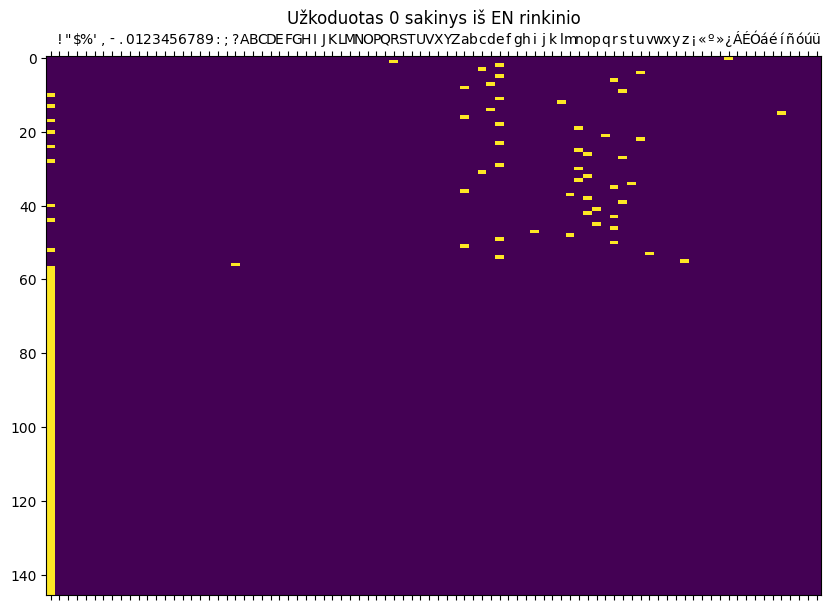

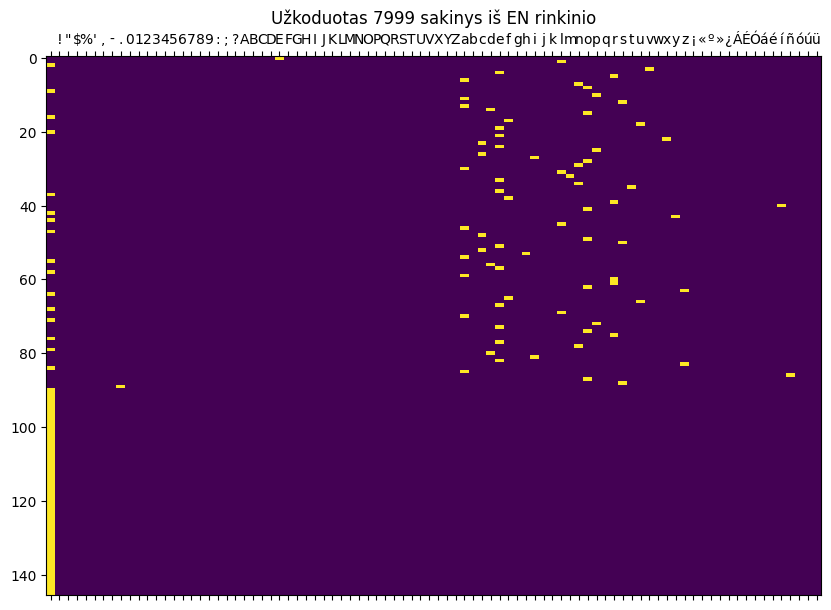

In [13]:
for i in [0, len(data)-1]:
  fig, ax = plt.subplots(figsize=(10, 7))
  ax.matshow(encoder_in_data[i], aspect='auto')
  ax.set_title(f'Užkoduotas {i} sakinys iš EN rinkinio')
  x_ticks_labels = [x for x in in_tokens_dict.keys()]
  ax.set_xticks(range(len(in_tokens_dict)), labels=x_ticks_labels)
  plt.show()

## 2. Modelis

Nustatome modelio parametrus:

In [14]:
BATCH_SIZE = 64
EPOCHS = 50
LATENT_DIM = 256

N_IN_TOKENS = len(in_tokens_dict)
N_OUT_TOKENS = len(out_tokens_dict)

Konstruojame modelį:

In [15]:
keras.utils.set_random_seed(812)
keras.backend.clear_session()

# konstruojame enkoderį: įvestis ir vienas LSTM sluoksnis
encoder_inputs = keras.Input(shape=(None, N_IN_TOKENS))
encoder = keras.layers.LSTM(LATENT_DIM, return_state=True)
# gauname LSTM sluoksnio būsenos vektorius, kurie eis į dekoderį
_, encoder_h, encoder_c = encoder(encoder_inputs)

# konstruojame dekoderį: įvestis, LSTM ir Dense sluoksniai
decoder_inputs = keras.Input(shape=(None, N_OUT_TOKENS))
decoder_lstm = keras.layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True)
# nustatome kad LSTM pradinė būsena ateis iš enkoderio
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[encoder_h, encoder_c])
# liko tik Dense sluoksnis, kuris turės tiek "klasių", kiek turime simbolių LT rinkinyje
decoder_dense = keras.layers.Dense(N_OUT_TOKENS, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

Kompiliuojame modelį su standartiniais parametrais:

In [16]:
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, 88)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None, 77)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 256), (None,   │        353,280 │ input_layer[0][0]      │
│                           │ 256), (None, 256)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 256),    │        342,016 │ input_layer_1[0][0],   │
│                           │ (None, 256), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 77)       │         19,789 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 715,085 (2.73 MB)

 Trainable params: 715,085 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Apmokymas

In [17]:
model.fit(
    batch_size = BATCH_SIZE,
    x = [encoder_in_data, decoder_in_data],
    y = decoder_out_data,
    epochs = EPOCHS,
    validation_split = 0.2
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7883 - loss: 1.4059 - val_accuracy: 0.7981 - val_loss: 0.8213
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7968 - loss: 0.8262 - val_accuracy: 0.7992 - val_loss: 0.7503
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7935 - loss: 0.7724 - val_accuracy: 0.7931 - val_loss: 0.7470
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7964 - loss: 0.7270 - val_accuracy: 0.7962 - val_loss: 0.7264
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8036 - loss: 0.6977 - val_accuracy: 0.8188 - val_loss: 0.6458
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8148 - loss: 0.6526 - val_accuracy: 0.8320 - val_loss: 0.5962
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8300 - loss: 0.6026 - val_accuracy: 0.8368 - val_loss: 0.5707
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8357 - loss: 0.5715 - val_accu

## 4. Modelio panaudojimas teksto vertimui

In [18]:
model.save("esp2en.keras")

Paruošiame išversto sakinio gavimo funkciją:

In [19]:
def translate(
    in_sentence: str,
    encoder: keras.Model,
    decoder: keras.Model,
    in_tokens_dict: dict,
    out_tokens_dict: dict) -> str:

  out_sentence = ""

  # gauname atvirkštinį simbolių žodyną kad galėtume perskaityti rezultatą:
  out_tokens_reverse = {v: k for k, v in out_tokens_dict.items()}

  # konvertuojame gautą sakinį į tokenus:
  in_seq = sentence2seq(in_sentence, in_tokens_dict, MAX_IN_LEN)
  # turime batch size lygu vienetui:
  in_seq = np.expand_dims(in_seq, axis=0)

  # gauname būsenos vektorius iš enkoderio:
  states = encoder.predict(in_seq, verbose=0)
  # konstruojame tuščią seką, kur saugosime prognozuotus simbolius:
  out_seq = np.zeros((1, 1, len(out_tokens_dict)))
  # pirmas simbolius turi būti tab'as:
  out_seq[0, 0, out_tokens_dict[START]] = 1.0

  while True:
    pred, h, c = decoder.predict([out_seq] + states, verbose=0)

    # traukiame geriausią spėjimą
    best_i = np.argmax(pred[0, -1, :])
    best_char = out_tokens_reverse[best_i]
    out_sentence += best_char

    # jeigu pasiekiame ilgio galą ar \n:
    if (best_char == '\n') or (len(out_sentence) > MAX_OUT_LEN):
      break

    # atnaujiname turimą seką sekančiam spėjimui:
    out_seq = np.zeros((1, 1, len(out_tokens_dict)))
    out_seq[0, 0, best_i] = 1.0
    # atnaujiname enkoderio būsenos vektorius:
    states = [h, c]

  return out_sentence

Paruošiame prognozavimo enkoderį:

In [20]:
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(LATENT_DIM,))
decoder_state_input_c = keras.Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [21]:
inference_encoder = keras.Model(
    model.input[0],  # enkoderio įversties sluoksnis
    [model.layers[2].output[1], model.layers[2].output[2]]  # enkoderio būsenos vektoriai
)

Prognozavimo dekoderio rekonstravimas reikalauja daugiau žingsnių:

In [22]:
decoder_inputs = model.input[1]  # dekoderio įvesties sluoksnis
decoder_lstm = model.layers[3]   # dekoderio LSTM sluoksnis
decoder_dense = model.layers[4]  # dekoderio Dense sluoksnis

# Konstruojame tuščią įvestį
decoder_states_inputs = [keras.Input(shape=(LATENT_DIM,)),
                         keras.Input(shape=(LATENT_DIM,))]
# Gauname išvestį ir būsenos vektorius po LSTM sluoksnio:
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs,
    initial_state=decoder_states_inputs
)
# Praleidžiame išvestį pro Dense sluoksnį:
decoder_outputs = decoder_dense(decoder_outputs)

# Galiausiai konstruojame modelį
inference_decoder = keras.Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + [state_h, state_c]
)

Panaudojame gautus modelius:

In [29]:
for phrase in ['La tecnología ha transformado nuestras vidas de manera significativa. Hoy en día, es común utilizar dispositivos electrónicos para']:
  print(translate(phrase,
                  encoder=encoder_model,
                  decoder=decoder_model,
                  in_tokens_dict=in_tokens_dict,
                  out_tokens_dict=out_tokens_dict))

I don't want to stop doing to the pare.

